In [35]:
import sys
sys.path.append('../')
from simCRN.multivariate_reg import read_eq_data_file
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score

# Baseline model: Random Forest

Reading in the data

In [2]:
Ci_all_array, Am_array, Cmin, Cmax, Ai = read_eq_data_file('4-4-2-asym-AB-AC.txt')

Prepare the data

In [3]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(Am_array, Ci_all_array, test_size=0.2, random_state=0)

# Z normalizing
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Decision Tree Model

In [36]:
decision_tree_model = DecisionTreeRegressor(criterion="squared_error", random_state=0)
decision_tree_model.fit(X_train_scaled, y_train)
y_hat_dt_train = decision_tree_model.predict(X_train_scaled)
y_hat_dt_test = decision_tree_model.predict(X_test_scaled)

In [37]:
dt_train_mae = mae(y_train, y_hat_dt_train, multioutput='raw_values')
dt_test_mae = mae(y_test, y_hat_dt_test, multioutput='raw_values')

print(f'The MAE on the training data for C₁ is {dt_train_mae[0]:.3}') # 3 significant figures
print(f'The MAE on the training data for C₂ is {dt_train_mae[1]:.3}')
print(f'The MAE on the test data for C₁ is {dt_test_mae[0]:.3}')
print(f'The MAE on the test data for C₂ is {dt_test_mae[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
means = np.mean(Ci_all_array, axis=0)
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, MAE/mean for C₁ is {dt_test_mae[0]/means[0]:.3}')
print(f'For the test data, MAE/mean for C₂ is {dt_test_mae[1]/means[1]:.3}')

The MAE on the training data for C₁ is 7.89e-09
The MAE on the training data for C₂ is 7.8e-09
The MAE on the test data for C₁ is 2e-08
The MAE on the test data for C₂ is 2.13e-08

The average value of C₁ is 7.61e-07
The average value of C₂ is 7.5e-07

For the test data, MAE/mean for C₁ is 0.0263
For the test data, MAE/mean for C₂ is 0.0284


In [38]:
dt_train_mse = mse(y_train, y_hat_dt_train, multioutput='raw_values')
dt_test_mse = mse(y_test, y_hat_dt_test, multioutput='raw_values')
dt_train_rmse = np.sqrt(dt_train_mse)
dt_test_rmse = np.sqrt(dt_test_mse)

print(f'The RMSE on the training data for C₁ is {dt_train_rmse[0]:.3}') # 3 significant figures
print(f'The RMSE on the training data for C₂ is {dt_train_rmse[1]:.3}')
print(f'The RMSE on the test data for C₁ is {dt_test_rmse[0]:.3}')
print(f'The RMSE on the test data for C₂ is {dt_test_rmse[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, RMSE/mean for C₁ is {dt_test_rmse[0]/means[0]:.3}')
print(f'For the test data, RMSE/mean for C₂ is {dt_test_rmse[1]/means[1]:.3}')

The RMSE on the training data for C₁ is 1.03e-08
The RMSE on the training data for C₂ is 1.02e-08
The RMSE on the test data for C₁ is 2.64e-08
The RMSE on the test data for C₂ is 2.91e-08

The average value of C₁ is 7.61e-07
The average value of C₂ is 7.5e-07

For the test data, RMSE/mean for C₁ is 0.0348
For the test data, RMSE/mean for C₂ is 0.0389


Get a sense of appropriate ccp_alpha values for minimal cost complexity pruning

In [39]:
decision_tree_model_complexity = DecisionTreeRegressor(criterion="squared_error", random_state=0)
pruning_path = decision_tree_model_complexity.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas, impurities = pruning_path.ccp_alphas, pruning_path.impurities
print(ccp_alphas)

[0.00000000e+00 2.25979950e-19 2.80596137e-19 2.83456633e-19
 2.87232053e-19 2.97634676e-19 2.98179810e-19 3.05670823e-19
 3.10142741e-19 3.12294255e-19 3.14632248e-19 3.21484030e-19
 3.22019913e-19 3.27842311e-19 3.35692487e-19 3.37895020e-19
 3.38092661e-19 3.40415422e-19 3.51083746e-19 3.51599462e-19
 3.52768254e-19 3.55379013e-19 3.55684061e-19 3.58714794e-19
 3.69615093e-19 3.74778766e-19 3.79251160e-19 3.82124384e-19
 3.82754046e-19 3.82772350e-19 3.83589113e-19 3.84149090e-19
 3.86822951e-19 3.87158767e-19 3.90118869e-19 3.98807457e-19
 4.01359503e-19 4.02027740e-19 4.02226567e-19 4.02853514e-19
 4.04868060e-19 4.08106464e-19 4.09044021e-19 4.11005777e-19
 4.12205149e-19 4.18181471e-19 4.18222174e-19 4.18427113e-19
 4.23991160e-19 4.24573782e-19 4.25797530e-19 4.27281529e-19
 4.27349379e-19 4.27643079e-19 4.36032848e-19 4.43473134e-19
 4.46773958e-19 4.47498608e-19 4.49582161e-19 4.49905718e-19
 4.60105083e-19 4.63526456e-19 4.63760043e-19 4.64613040e-19
 4.65306810e-19 4.660765

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

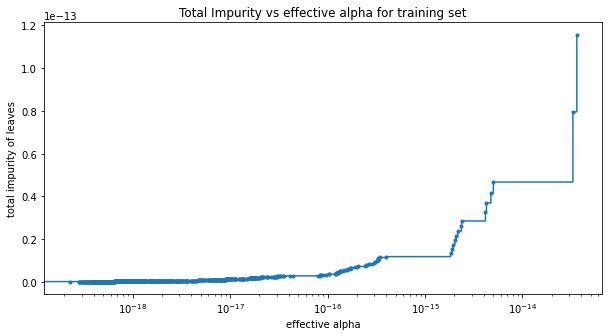

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
ax.semilogx(ccp_alphas[:-1], impurities[:-1], marker=".", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Random Forest Model

In [6]:
random_forest_model = RandomForestRegressor(criterion="squared_error", random_state=0)
random_forest_model.fit(X_train_scaled, y_train)
y_hat_train = random_forest_model.predict(X_train_scaled)
y_hat_test = random_forest_model.predict(X_test_scaled)

In [7]:
train_mae = mae(y_train, y_hat_train, multioutput='raw_values')
test_mae = mae(y_test, y_hat_test, multioutput='raw_values')

print(f'The MAE on the training data for C₁ is {train_mae[0]:.3}') # 3 significant figures
print(f'The MAE on the training data for C₂ is {train_mae[1]:.3}')
print(f'The MAE on the test data for C₁ is {test_mae[0]:.3}')
print(f'The MAE on the test data for C₂ is {test_mae[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
means = np.mean(Ci_all_array, axis=0)
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, MAE/mean for C₁ is {test_mae[0]/means[0]:.3}')
print(f'For the test data, MAE/mean for C₂ is {test_mae[1]/means[1]:.3}')

The MAE on the training data for C₁ is 5.42e-09
The MAE on the training data for C₂ is 5.66e-09
The MAE on the test data for C₁ is 9.02e-09
The MAE on the test data for C₂ is 9.6e-09

The average value of C₁ is 7.61e-07
The average value of C₂ is 7.5e-07

For the test data, MAE/mean for C₁ is 0.0119
For the test data, MAE/mean for C₂ is 0.0128


In [9]:
train_mse = mse(y_train, y_hat_train, multioutput='raw_values')
test_mse = mse(y_test, y_hat_test, multioutput='raw_values')
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'The RMSE on the training data for C₁ is {train_rmse[0]:.3}') # 3 significant figures
print(f'The RMSE on the training data for C₂ is {train_rmse[1]:.3}')
print(f'The RMSE on the test data for C₁ is {test_rmse[0]:.3}')
print(f'The RMSE on the test data for C₂ is {test_rmse[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, RMSE/mean for C₁ is {test_rmse[0]/means[0]:.3}')
print(f'For the test data, RMSE/mean for C₂ is {test_rmse[1]/means[1]:.3}')

The RMSE on the training data for C₁ is 6.92e-09
The RMSE on the training data for C₂ is 7.24e-09
The RMSE on the test data for C₁ is 1.32e-08
The RMSE on the test data for C₂ is 1.25e-08

The average value of C₁ is 7.61e-07
The average value of C₂ is 7.5e-07

For the test data, RMSE/mean for C₁ is 0.0174
For the test data, RMSE/mean for C₂ is 0.0166


In [13]:
train_r2 = r2_score(y_train, y_hat_train, multioutput='raw_values')
test_r2 = r2_score(y_test, y_hat_test, multioutput='raw_values')

print(f'The R² on the training data for C₁ is {train_r2[0]:.3}') # 3 significant figures
print(f'The R² on the training data for C₂ is {train_r2[1]:.3}')
print(f'The R² on the test data for C₁ is {test_r2[0]:.3}')
print(f'The R² on the test data for C₂ is {test_r2[1]:.3}')

The R² on the training data for C₁ is 1.0
The R² on the training data for C₂ is 1.0
The R² on the test data for C₁ is 0.999
The R² on the test data for C₂ is 0.999


# Hyperparameter optimization

In [29]:
n_estimators_list = [20, 40, 80, 100, 160, 320, 640, 1280]
min_samples_split_list = [2, 8, 10, 12, 24]
max_depth_list = [2, 4, 8, 10, None]
max_depth_list = [2, 4, 8, 10, None]
parameter_space = {'n_estimators': hp.choice('n_estimators', n_estimators_list), \
                   'min_samples_split': hp.choice('min_samples_split', min_samples_split_list), \
                   'max_depth': hp.choice('max_depth', max_depth_list)}

In [30]:
print(f"Parameter Space Size: {len(n_estimators_list)*len(min_samples_split_list)*len(max_depth_list)}")

Parameter Space Size: 160


In [5]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score

In [10]:
def model_eval(args):

    '''Take suggested arguments and perform model evaluation'''
    
    model = RandomForestRegressor(criterion="squared_error", n_estimators=args['n_estimators'], \
                                  min_samples_split=args['min_samples_split'], max_depth=args['max_depth'])
    
    scores = cross_val_score(model, X_train_scaled, y=y_train, scoring='neg_mean_squared_error')

    cv_score = np.mean(scores)

    # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
    return -cv_score

In [17]:
print("Start trials") 

trials = Trials()
best = fmin(model_eval, parameter_space, algo=tpe.suggest, max_evals=500, trials=trials)

Start trials
100%|██████████| 300/300 [38:36<00:00,  7.72s/trial, best loss: 4.11578730035005e-16]   
Best parameter set: {'max_depth': 2, 'min_samples_split': 0, 'n_estimators': 5}
Best loss from CV: 4.1e-16


In [20]:
print("Best parameter set: {}".format(best))
print("Best loss from CV: {:.2}".format(trials.best_trial['result']['loss']))
print("Best RMSE loss from CV: {:.3}".format(np.sqrt(trials.best_trial['result']['loss'])))

Best RMSE loss from CV: 2.03e-08


In [33]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 8.979468694964462e-15, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'max_depth': [0], 'min_samples_split': [0], 'n_estimators': [0]},
   'vals': {'max_depth': [1], 'min_samples_split': [1], 'n_estimators': [0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 4, 27, 3, 1, 46, 828000),
  'refresh_time': datetime.datetime(2022, 4, 27, 3, 1, 47, 68000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 7.180357139077341e-16, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'max_depth': [1], 'min_samples_split': [1], 'n_estimators': [1]},
   'vals': {'max_depth': [2], 'min_samples_split': [2], 'n_estimators': [6]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 4, 27, 3, 1, 47, 7

In [25]:
optimized_random_forest_model = RandomForestRegressor(criterion="squared_error", \
                                                      n_estimators=n_estimators_list[best['n_estimators']], 
                                                      max_depth=max_depth_list[best['max_depth']], \
                                                      min_samples_split=min_samples_split_list[best['min_samples_split']])
optimized_random_forest_model.fit(X_train_scaled, y_train)
optimized_y_hat_train = optimized_random_forest_model.predict(X_train_scaled)
optimized_y_hat_test = optimized_random_forest_model.predict(X_test_scaled)

In [26]:
optimized_train_mse = mse(y_train, optimized_y_hat_train, multioutput='raw_values')
optimized_test_mse = mse(y_test, optimized_y_hat_test, multioutput='raw_values')
optimized_train_rmse = np.sqrt(optimized_train_mse)
optimized_test_rmse = np.sqrt(optimized_test_mse)

print(f'The RMSE on the training data for C₁ is {optimized_train_rmse[0]:.3}') # 3 significant figures
print(f'The RMSE on the training data for C₂ is {optimized_train_rmse[1]:.3}')
print(f'The RMSE on the test data for C₁ is {optimized_test_rmse[0]:.3}')
print(f'The RMSE on the test data for C₂ is {optimized_test_rmse[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, RMSE/mean for C₁ is {optimized_test_rmse[0]/means[0]:.3}')
print(f'For the test data, RMSE/mean for C₂ is {optimized_test_rmse[1]/means[1]:.3}')

The RMSE on the training data for C₁ is 1.36e-08
The RMSE on the training data for C₂ is 1.34e-08
The RMSE on the test data for C₁ is 1.99e-08
The RMSE on the test data for C₂ is 1.62e-08

The average value of C₁ is 7.61e-07
The average value of C₂ is 7.5e-07

For the test data, RMSE/mean for C₁ is 0.0261
For the test data, RMSE/mean for C₂ is 0.0216
